## Import packages and set seed

- It is highly probable that the folder "auxiliary_scripts" will change its name in the future.
- If this happens then it would be converted into a package called "wavesuite_auxiliary_scripts" and it would have to be installed and imported

In [1]:
import sys

sys.path.insert(0, '../../auxiliary_scripts/')

# test_number = 1    #1 or 2

In [2]:
import numpy as np
import vtktools
import matplotlib.pyplot as plt 

import time 

import torch
import torch.nn as nn 

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [3]:
from test_just_model1AE import model1_variant1 ,  model1_variant2 ,  model1_variant3

In [4]:
from train_AE_functions import set_seed , train_AE_epoch, validate_AE_epoch , model_MSE_error

from graph_functions import get_node_features, get_complete_edge_list , create_graph_data_list_mnist
from plot_results_mnist import evaluate_and_plot_mnist , compare_three_plots_models_mnist 

from rank_models import plot_losses , rank_losses

In [5]:
from livelossplot import PlotLosses 

set_seed(42)

True

## Create the list of Data objects where each element is a graph

In [6]:
graph_data_list_mnist , n_points = create_graph_data_list_mnist(num_samples_to_use=1000, mnist_path="../../../Datasets/")

In [7]:
graph_data_list_mnist[0]

Data(x=[784, 1], edge_index=[2, 2970])

## Shuffle graph_data_list before splitting

In [8]:
#Compute the number of graphs
n_graphs = len(graph_data_list_mnist)

#Compute one random permutation
permutation0 = np.random.permutation(n_graphs)

In [9]:
shuffle = True

if shuffle:
    #Reorganize graph_data_list taking into account the previous random permutation
    input_graph_data_list = [graph_data_list_mnist[entry] for entry in permutation0]
else: 
    input_graph_data_list = graph_data_list_mnist

## Create DataLoaders

In [10]:
n_graphs = len(input_graph_data_list)

graph_data_list_train = input_graph_data_list[:int(n_graphs * 0.8)]
graph_data_list_validation = input_graph_data_list[int(n_graphs * 0.8):int(n_graphs * 0.9)]
graph_data_list_test = input_graph_data_list[int(n_graphs * 0.9):]

print(len(graph_data_list_train))
print(len(graph_data_list_validation))
print(len(graph_data_list_test))

800
100
100


In [11]:
NUM_GRAPHS_PER_BATCH = 32

train_loader = DataLoader(graph_data_list_train, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
validation_loader = DataLoader(graph_data_list_validation, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(graph_data_list_test, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

## Copy train_AE frunction but modify the available model1_variants

In [12]:
def train_AE(train_loader, validation_loader, 
             num_nodes, num_features, embedding_sequence, latent_space_dim,
             ae_model_type='classic_AE', num_epochs=50, plot_losses=True, 
             seed=42, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ,
             use_sgd_instead_of_adam=False, lr=1e-1, momentum=0.2):
    
    set_seed(seed)
    
    invalid_entry = False
    
    if ae_model_type=='model1_variant1':
        model = model1_variant1(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model1_variant2':
        model = model1_variant2(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model1_variant3':
        model = model1_variant3(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    else:
        invalid_entry = True
        print('\n An invalid ae_model_type was provided, a classic AE was used as default')
        # model = classic_AE(num_nodes, num_features, latent_space_dim).to(device)
    
    ## The ADAM is the default, since the ADAM optimizer performs better in this case compared against SGD  
    optimizer = torch.optim.Adam(model.parameters())
    if use_sgd_instead_of_adam:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    ## The loss here is the mean_squared_error because the model is an AE
    criterion = nn.MSELoss()
    
    if plot_losses:
        liveloss = PlotLosses()
    loss_register = []
    
    for epoch in range(num_epochs):
        #During each epoch update the parameters
        train_temp_loss = train_AE_epoch(model, optimizer, criterion, train_loader, device, num_nodes)
        
        #Optional: Check the validation loss in each epoch
        validation_temp_loss = validate_AE_epoch(model, criterion, validation_loader, device, num_nodes) 
        
        #Compute the losses in each iteration 
        logs = {}
        logs['' + 'log loss'] = train_temp_loss.item()
        logs['val_' + 'log loss'] = validation_temp_loss.item()
        loss_register.append(logs)
        
        #Optionally plot the train and validation loss   
        if plot_losses:
            liveloss.update(logs)
            liveloss.draw()
            
    if invalid_entry == True:
        print('\n An invalid ae_model_type was provided, a classic AE was used as default') 
        
    print("\n Number of parameters: ", sum(p.numel() for p in model.parameters()))
    
    #At the end just return 1. the model with the trained parameters and 2. the list of losses in every epoch
    return model, loss_register 

## Let's train some models

In [13]:
#This dictionary stores the losses results of the models
results_variants = {}

In [14]:
#These are the models specifications
num_features = 1  #This is always 1
embedding_sequence = None 
latent_space_dim = 32
num_epochs = 80   

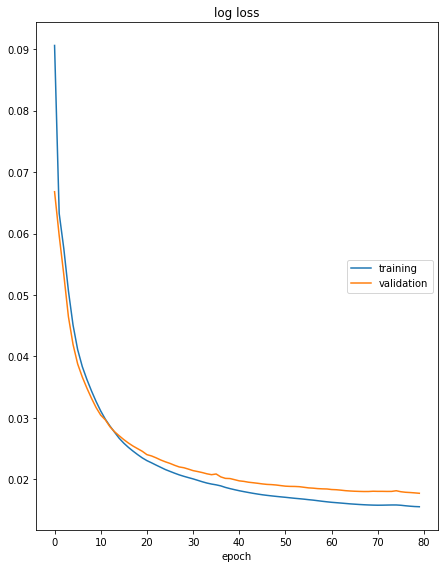

log loss
	training         	 (min:    0.016, max:    0.091, cur:    0.016)
	validation       	 (min:    0.018, max:    0.067, cur:    0.018)

 Number of parameters:  105392
Time taken:  27.191928386688232


In [15]:
start = time.time()

var_name = 'test'+'_variant1'

variant1, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model1_variant1', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

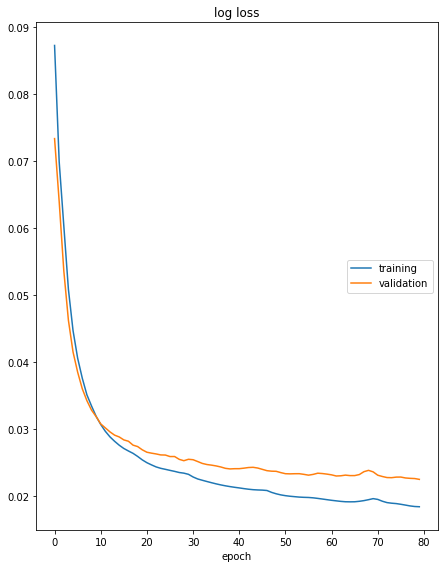

log loss
	training         	 (min:    0.018, max:    0.087, cur:    0.018)
	validation       	 (min:    0.022, max:    0.073, cur:    0.022)

 Number of parameters:  105392
Time taken:  26.171900510787964


In [16]:
start = time.time()

var_name = 'test'+'_variant2'

variant2, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model1_variant2', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

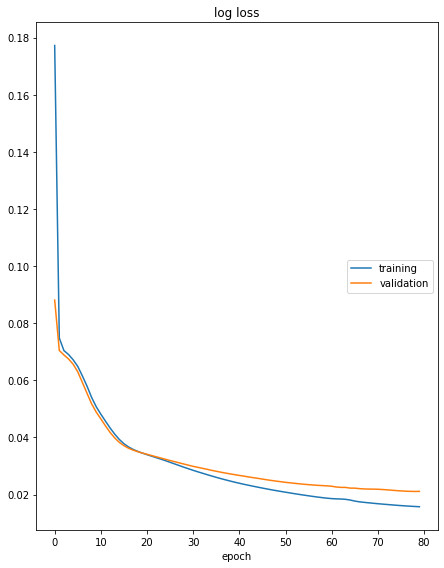

log loss
	training         	 (min:    0.016, max:    0.177, cur:    0.016)
	validation       	 (min:    0.021, max:    0.088, cur:    0.021)

 Number of parameters:  105392
Time taken:  26.092758893966675


In [17]:
start = time.time()

var_name = 'test'+'_variant3'

variant3, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model1_variant3', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

## MSE results

In [18]:
variants_names = list( results_variants.keys() )

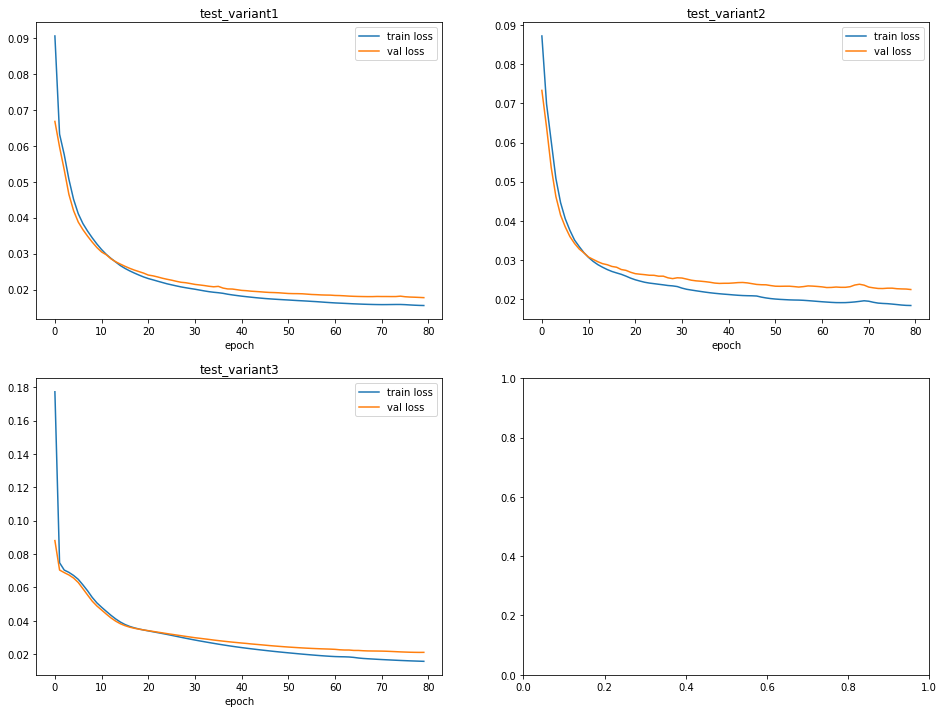

In [19]:
filename = 'model1_mnist_test'+'_variants_losses.png'
plot_losses(results_variants, variants_names, filename=filename, figsize=(16,12))

In [20]:
rank_losses(results_variants, variants_names, selected_epoch = int(num_epochs/4) )

,variants_name,final_validation_loss
0,test_variant1,0.024567
1,test_variant2,0.026857
2,test_variant3,0.034528


In [21]:
rank_losses(results_variants, variants_names, selected_epoch = int(num_epochs/2) )

,variants_name,final_validation_loss
0,test_variant1,0.019946
1,test_variant2,0.024042
2,test_variant3,0.026970


In [22]:
first_column_model_name = 'Model1'
filename = 'model1_mnist_test'+'_variants_losses.csv'

df_losses = rank_losses(results_variants, variants_names, selected_epoch = num_epochs,
                       first_column_model_name = first_column_model_name, filename = filename )

df_losses

CSV was saved


,Model name,variants_name,final_validation_loss
0,Model1,test_variant1,0.017736
1,Model1,test_variant3,0.021112
2,Model1,test_variant2,0.022448


The model that performed the best in this case was variant1. However, variant1 comes with a dirty background when plotting and also the difference between the model losses are smaller (almost negligible) when compared with the differences in the air pollution dataset. 

Therefore, for model1 I am going to choose variant3.

# Plot the results

Indexes plotted [51 92 14 71 60]


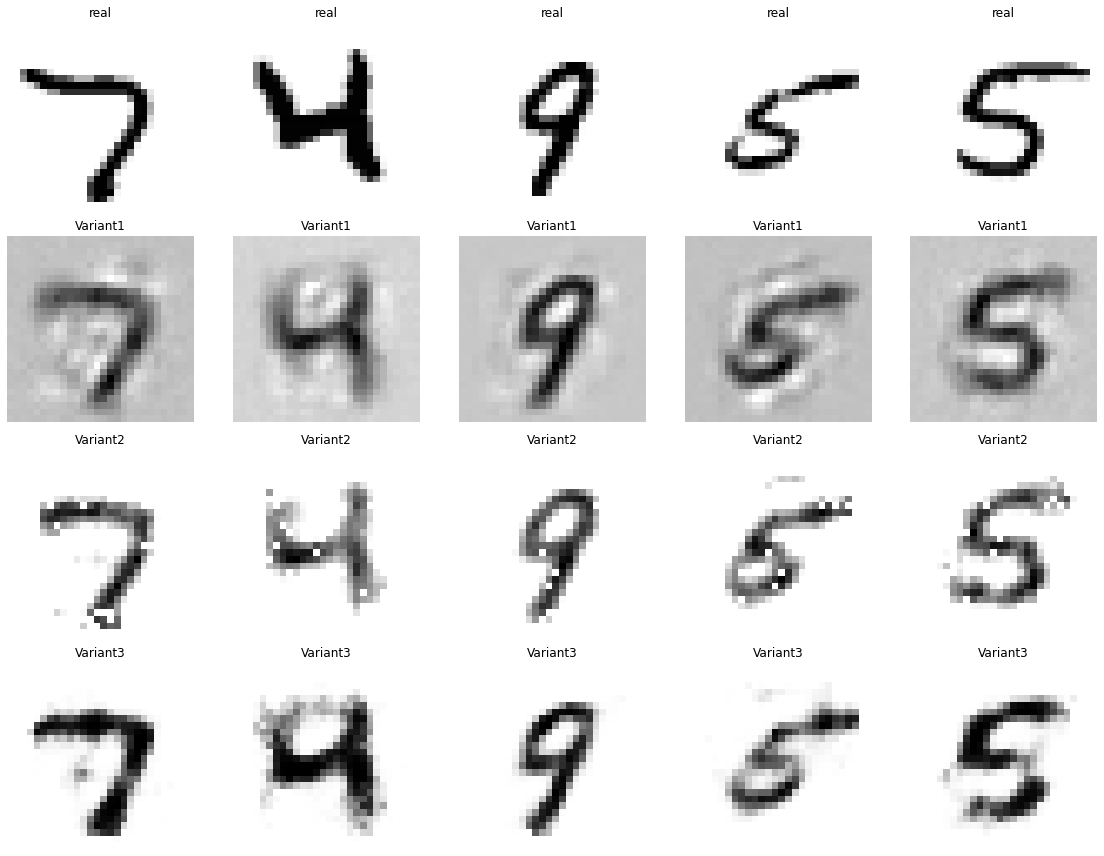

In [23]:
compare_three_plots_models_mnist(variant1, variant2, variant3, 
                                graph_data_list_test, nDisplay=5, axis_off=True, 
                                random=True, batch_size=32,
                                 set_pred_labels_as = ["Variant1", "Variant2", "Variant3"],
                                save_fig=True, filename='mnist_model1_variants.png' )

Indexes plotted [20 82 86 74 74]


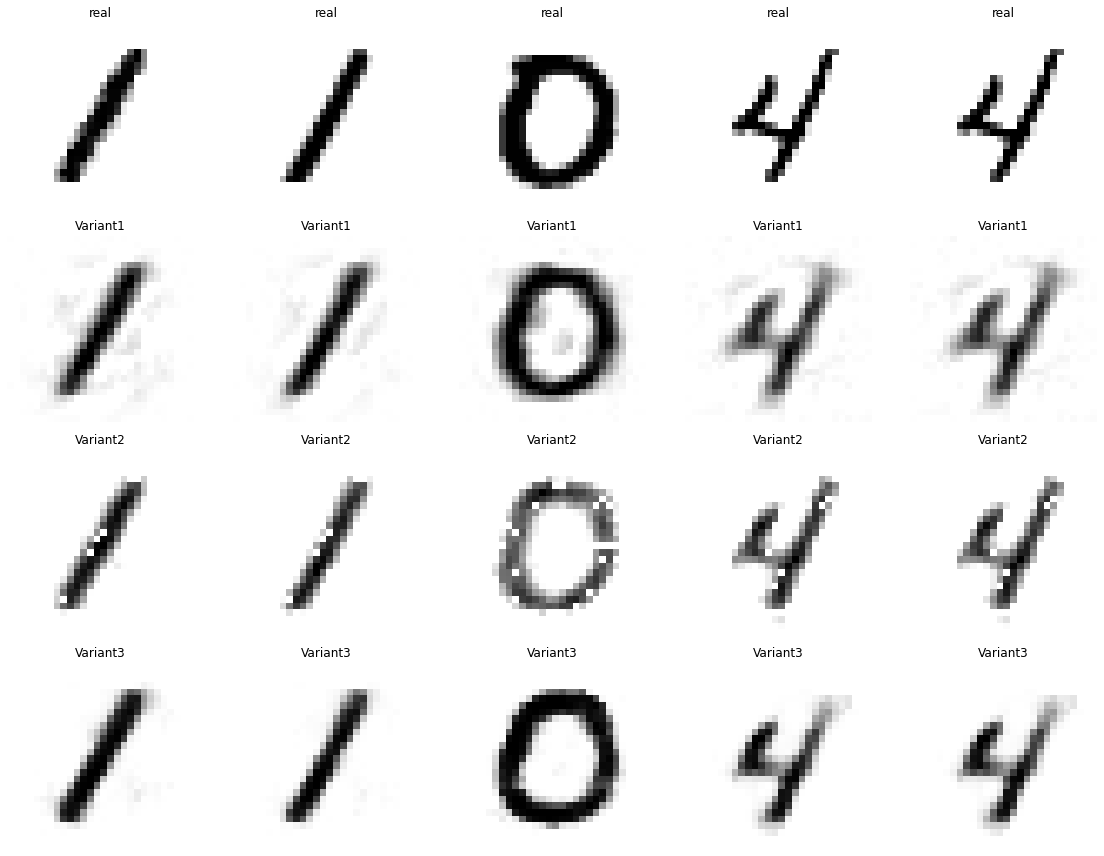

In [24]:
compare_three_plots_models_mnist(variant1, variant2, variant3, 
                                graph_data_list_test, nDisplay=5, axis_off=True, 
                                random=True, batch_size=32,
                                 set_pred_labels_as = ["Variant1", "Variant2", "Variant3"],
                                save_fig=True, filename='mnist_model1_variants.png',
                                cut_preds_01_model1 = True )

It is also posible to plot the model results separately. Note that the best images are produces by variant3

Indexes plotted [87 99 23  2 21 52  1 87]


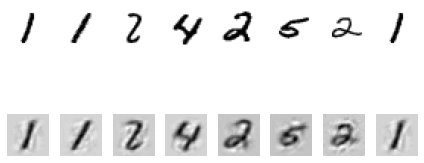

In [25]:
evaluate_and_plot_mnist(variant1, test_loader, 8)

Indexes plotted [29 37  1 63 59 20 32 75]


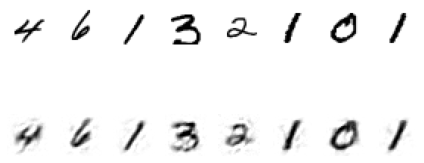

In [26]:
evaluate_and_plot_mnist(variant1, test_loader, 8, cut_preds_01=True)

Indexes plotted [57 21 88 48 90 58 41 91]


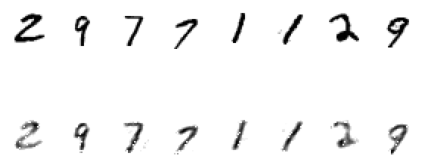

In [27]:
evaluate_and_plot_mnist(variant2, test_loader, 8)

Indexes plotted [59 79 14 61 61 46 61 50]


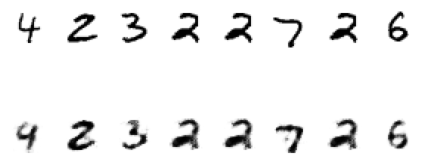

In [28]:
evaluate_and_plot_mnist(variant3, test_loader, 8)